In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy.stats import wilcoxon

In [2]:
def wilcox_test(plotdf, metric='rmse'):
    '''
    given plotdf, run wilcox test comparing original to distilled models
    '''
    original = plotdf[plotdf['model']=='original'][metric].values.flatten()
    distilled = plotdf[plotdf['model']=='distilled'][metric].values.flatten()
    res = wilcoxon(original, distilled)
    return res

In [38]:
# load data for performance curves 
deepstarr_performance = pd.read_csv('DeepSTARR_performance_plotdf.csv')

# subset for Pearson r and Dev 
deepstarr_dev_performance = deepstarr_performance[(deepstarr_performance['metric']=='Pearson') & (deepstarr_performance['output']=='Dev')]

# subset for Pearson r and Dev-std
deepstarr_dev_epistemic = deepstarr_performance[(deepstarr_performance['metric']=='Pearson') & (deepstarr_performance['output']=='Dev-std')]

# rename original -> individual
mapping = {'original': 'individual', 
           'distilled': 'distilled',
           'average': 'average'}
deepstarr_dev_performance['model'] = deepstarr_dev_performance['label'].map(mapping)

/tmp/ipykernel_887218/3797193620.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deepstarr_dev_performance['model'] = deepstarr_dev_performance['label'].map(mapping)


In [4]:
# load data from Dev SHAP RMSE analysis
dev_shap_rmse = pd.read_csv("Dev-mean_shap_rmse_plotdf.csv")

# calculate mean across models
dev_shap_mean_rmse = dev_shap_rmse.groupby('model').mean('rmse')['rmse'].to_dict()
dev_shap_mean_rmse

{'distilled': 0.002744586871685474, 'original': 0.003337234856594746}

In [7]:
wilcox_test(dev_shap_rmse).pvalue

0.0

In [8]:
# load data from Dev SHAP variance
dev_shap_var = pd.read_csv("Dev-mean_shap_std_plotdf.csv")


In [9]:
# load data for distilled models trained w/ augmentations
aug_df = pd.read_csv('augmentation_performance_plotdf.csv')

# subset for Pearson metric and augmentations +train
aug_df_pearson = aug_df[(aug_df['metric']=='Pearson') & (~aug_df['aug'].isin(['evoaug','mutagenesis','random']))]

# rename augmentations to remove +train
# Define mapping dictionary
# def map_values(x):
#     if x > 15:
#         return 'High'
#     else:
#         return 'Low'
mapping = {'evoaug+train': 'evoaug', 
           'mutagenesis+train': 'mutagenesis',
           'random+train': 'random',
           'none': 'none'}

# Map values in 'category' column using the mapping dictionary
aug_df_pearson['aug'] = aug_df_pearson['aug'].map(mapping)

/tmp/ipykernel_887218/2359731604.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug_df_pearson['aug'] = aug_df_pearson['aug'].map(mapping)


# Plot 

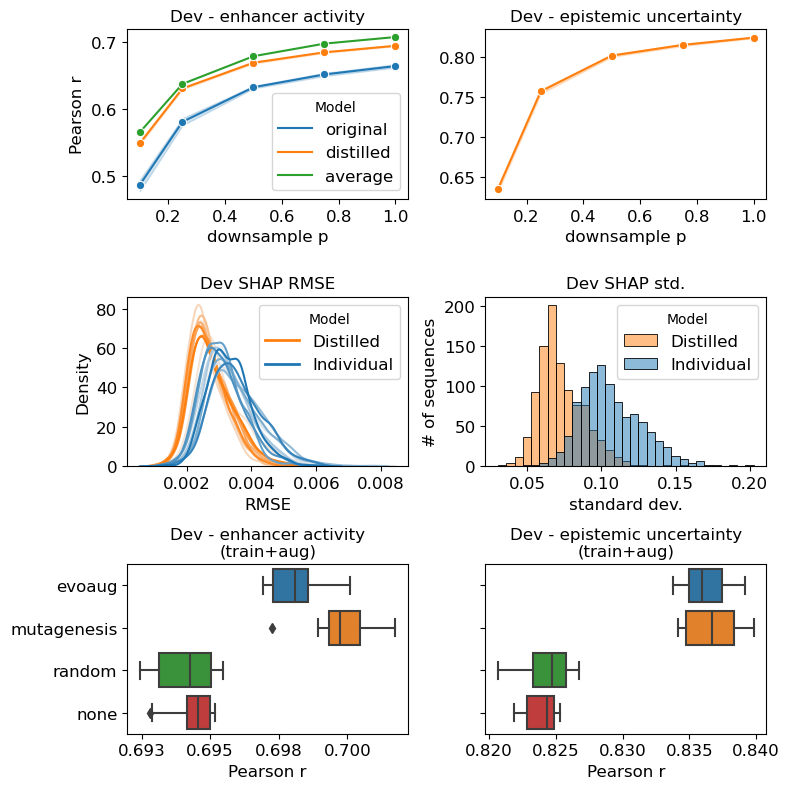

In [25]:
fig, axs = plt.subplots(3,2,figsize=(8,8))

# DeepSTARR performance curves - Dev (activity/mean)
sns.lineplot(data=deepstarr_dev_performance, x="downsample", y="value", hue='model',marker='o', ax=axs[0][0])
axs[0][0].legend(title='Model', fontsize=12)
axs[0][0].set_ylabel('Pearson r', fontsize=12)
axs[0][0].set_xlabel('downsample p', fontsize=12)
axs[0][0].set_title('Dev - enhancer activity', fontsize=12)
axs[0][0].tick_params(axis='both', which='major', labelsize=12)

# DeepSTARR epistemic uncertainty performance
palette = {'Dev-std': 'tab:orange'}
sns.lineplot(deepstarr_dev_epistemic, x="downsample", y="value", hue="output", marker='o', legend=False, ax=axs[0][1], palette=palette)
axs[0][1].set_ylabel('', fontsize=12)
axs[0][1].set_xlabel('downsample p', fontsize=12)
axs[0][1].set_title('Dev - epistemic uncertainty', fontsize=12)
axs[0][1].tick_params(axis='both', which='major', labelsize=12)

# SHAP RMSE analysis
# sns.kdeplot(dev_shap_rmse[dev_shap_rmse['model']=='distilled'], x='rmse', hue='model_ix', ax=axs[1][0], palette=sns.light_palette("#5EB1BF", reverse=True, as_cmap=True), label='distilled')
# sns.kdeplot(dev_shap_rmse[dev_shap_rmse['model']=='original'], x='rmse', hue='model_ix', ax=axs[1][0], palette=sns.light_palette("#EF7B45", reverse=True, as_cmap=True), label='original')
sns.kdeplot(dev_shap_rmse[dev_shap_rmse['model']=='distilled'], x='rmse', hue='model_ix', ax=axs[1][0], palette=sns.light_palette("tab:orange", reverse=True, as_cmap=True), label='distilled')
sns.kdeplot(dev_shap_rmse[dev_shap_rmse['model']=='original'], x='rmse', hue='model_ix', ax=axs[1][0], palette=sns.light_palette("tab:blue", reverse=True, as_cmap=True), label='original')
axs[1][0].get_legend().set_visible(False)
custom_lines = [Line2D([0], [0], color="tab:orange", lw=2),
                Line2D([0], [0], color="tab:blue", lw=2)]
axs[1][0].legend(custom_lines, ['Distilled', 'Individual'], title='Model',fontsize=12)
# axs[1][0].text(0.004, 50, f"Mean: {dev_shap_mean_rmse['distilled']:.3E}", fontsize=13, color="#5EB1BF")
# axs[1][0].text(0.004, 40, f"Mean: {dev_shap_mean_rmse['original']:.3E}", fontsize=13, color="#EF7B45")
# axs[1][0].text(0.005, 25, f"p={wilcox_test(dev_shap_rmse).pvalue}", fontsize=13)
axs[1][0].set_xlabel(f'RMSE', fontsize=12)
axs[1][0].set_ylabel('Density', fontsize=12)
axs[1][0].tick_params(axis='both', which='major', labelsize=12)
axs[1][0].set_title('Dev SHAP RMSE', fontsize=12)

# SHAP std across models 
palette = {'distilled': 'tab:orange', 'original': 'tab:blue'}
sns.histplot(data=dev_shap_var, x='stdev', hue='model', ax=axs[1][1], palette=palette)
axs[1][1].legend(['Distilled', 'Individual'], title='Model', fontsize=12)
axs[1][1].set_title('Dev SHAP std.', fontsize=12)
axs[1][1].tick_params(axis='both', which='major', labelsize=12)
# axs[1][1].text(0.13, 75, f"p={(wilcox_test(dev_shap_var, metric='stdev').pvalue):.3g}", fontsize=11)
axs[1][1].set_xlabel('standard dev.', fontsize=12)
axs[1][1].set_ylabel('# of sequences', fontsize=12)

# Define a formatter function
def format_func(value, tick_number):
    return f"{value:.3f}"  # Format to 2 decimal places

# augmentation results
sns.boxplot(data=aug_df_pearson[aug_df_pearson['head']=='Dev'],
            y='aug', x='value', ax=axs[2][0])
axs[2][0].set_xlabel('Pearson r', fontsize=12)
axs[2][0].set_ylabel('')
axs[2][0].tick_params(axis='both', which='major', labelsize=12)
axs[2][0].xaxis.set_major_formatter(FuncFormatter(format_func))
axs[2][0].set_title('Dev - enhancer activity\n(train+aug)', fontsize=12)

sns.boxplot(data=aug_df_pearson[aug_df_pearson['head']=='Dev-std'],
            y='aug', x='value', ax=axs[2][1])
axs[2][1].set_xlabel('Pearson r', fontsize=12)
axs[2][1].set_ylabel('')
# axs[2][1].set_yticks([])
axs[2][1].tick_params(axis='y', which='both', labelleft=False)
axs[2][1].tick_params(axis='x', which='major', labelsize=12)
axs[2][1].set_title('Dev - epistemic uncertainty\n(train+aug)', fontsize=12)

fig.tight_layout()
fig.show()
# fig.savefig("Fig1_DeepSTARR_results_summary.pdf")
# fig.savefig("Fig1_DeepSTARR_results_summary.png", dpi=300)

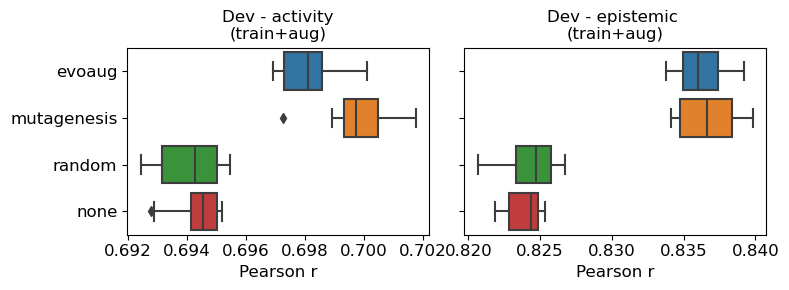

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))
# Define a formatter function
def format_func(value, tick_number):
    return f"{value:.3f}"  # Format to 2 decimal places

# augmentation results
sns.boxplot(data=aug_df_pearson[aug_df_pearson['head']=='Dev'],
            y='aug', x='value', ax=axs[0])
axs[0].set_xlabel('Pearson r', fontsize=12)
axs[0].set_ylabel('')
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].xaxis.set_major_formatter(FuncFormatter(format_func))
axs[0].set_title('Dev - activity\n(train+aug)', fontsize=12)

sns.boxplot(data=aug_df_pearson[aug_df_pearson['head']=='Dev-std'],
            y='aug', x='value', ax=axs[1])
axs[1].set_xlabel('Pearson r', fontsize=12)
axs[1].set_ylabel('')
# axs[2][1].set_yticks([])
axs[1].tick_params(axis='y', which='both', labelleft=False)
axs[1].tick_params(axis='x', which='major', labelsize=12)
axs[1].set_title('Dev - epistemic \n(train+aug)', fontsize=12)
fig.tight_layout()
fig.savefig("Fig1_bottom.pdf",)

In [37]:
deepstarr_dev_performance

,metric,model_ix,downsample,label,output,value
32,Pearson,1.0,0.10,original,Dev,0.492809
35,Pearson,2.0,0.10,original,Dev,0.484501
38,Pearson,3.0,0.10,original,Dev,0.463071
41,Pearson,4.0,0.10,original,Dev,0.500213
44,Pearson,5.0,0.10,original,Dev,0.462552
...,...,...,...,...,...,...
901,Pearson,NaN,0.10,average,Dev,0.565317
904,Pearson,NaN,0.25,average,Dev,0.637376
907,Pearson,NaN,0.50,average,Dev,0.678762
910,Pearson,NaN,0.75,average,Dev,0.697562


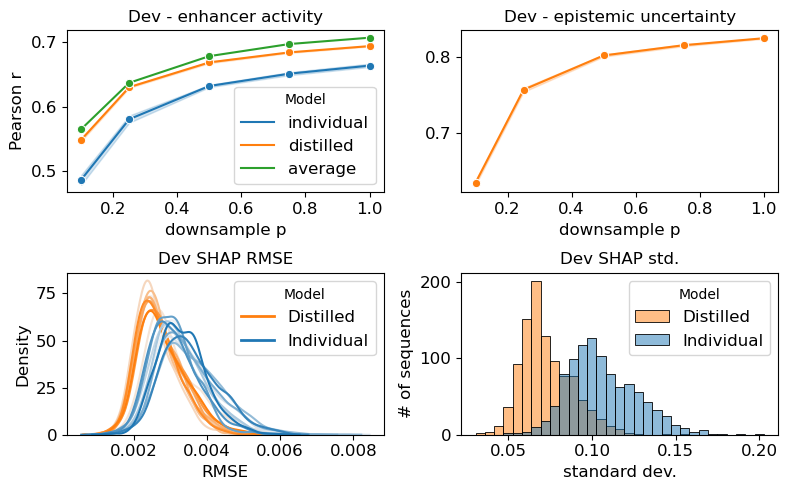

In [40]:
fig, axs = plt.subplots(2,2,figsize=(8,5))

# DeepSTARR performance curves - Dev (activity/mean)
sns.lineplot(data=deepstarr_dev_performance, x="downsample", y="value", hue='model',marker='o', ax=axs[0][0])
axs[0][0].legend(title='Model', fontsize=12)
axs[0][0].set_ylabel('Pearson r', fontsize=12)
axs[0][0].set_xlabel('downsample p', fontsize=12)
axs[0][0].set_title('Dev - enhancer activity', fontsize=12)
axs[0][0].tick_params(axis='both', which='major', labelsize=12)

# DeepSTARR epistemic uncertainty performance
palette = {'Dev-std': 'tab:orange'}
sns.lineplot(deepstarr_dev_epistemic, x="downsample", y="value", hue="output", marker='o', legend=False, ax=axs[0][1], palette=palette)
axs[0][1].set_ylabel('', fontsize=12)
axs[0][1].set_xlabel('downsample p', fontsize=12)
axs[0][1].set_title('Dev - epistemic uncertainty', fontsize=12)
axs[0][1].tick_params(axis='both', which='major', labelsize=12)

# SHAP RMSE analysis
# sns.kdeplot(dev_shap_rmse[dev_shap_rmse['model']=='distilled'], x='rmse', hue='model_ix', ax=axs[1][0], palette=sns.light_palette("#5EB1BF", reverse=True, as_cmap=True), label='distilled')
# sns.kdeplot(dev_shap_rmse[dev_shap_rmse['model']=='original'], x='rmse', hue='model_ix', ax=axs[1][0], palette=sns.light_palette("#EF7B45", reverse=True, as_cmap=True), label='original')
sns.kdeplot(dev_shap_rmse[dev_shap_rmse['model']=='distilled'], x='rmse', hue='model_ix', ax=axs[1][0], palette=sns.light_palette("tab:orange", reverse=True, as_cmap=True), label='distilled')
sns.kdeplot(dev_shap_rmse[dev_shap_rmse['model']=='original'], x='rmse', hue='model_ix', ax=axs[1][0], palette=sns.light_palette("tab:blue", reverse=True, as_cmap=True), label='original')
axs[1][0].get_legend().set_visible(False)
custom_lines = [Line2D([0], [0], color="tab:orange", lw=2),
                Line2D([0], [0], color="tab:blue", lw=2)]
axs[1][0].legend(custom_lines, ['Distilled', 'Individual'], title='Model',fontsize=12)
# axs[1][0].text(0.004, 50, f"Mean: {dev_shap_mean_rmse['distilled']:.3E}", fontsize=13, color="#5EB1BF")
# axs[1][0].text(0.004, 40, f"Mean: {dev_shap_mean_rmse['original']:.3E}", fontsize=13, color="#EF7B45")
# axs[1][0].text(0.005, 25, f"p={wilcox_test(dev_shap_rmse).pvalue}", fontsize=13)
axs[1][0].set_xlabel(f'RMSE', fontsize=12)
axs[1][0].set_ylabel('Density', fontsize=12)
axs[1][0].tick_params(axis='both', which='major', labelsize=12)
axs[1][0].set_title('Dev SHAP RMSE', fontsize=12)

# SHAP std across models 
palette = {'distilled': 'tab:orange', 'original': 'tab:blue'}
sns.histplot(data=dev_shap_var, x='stdev', hue='model', ax=axs[1][1], palette=palette)
axs[1][1].legend(['Distilled', 'Individual'], title='Model', fontsize=12)
axs[1][1].set_title('Dev SHAP std.', fontsize=12)
axs[1][1].tick_params(axis='both', which='major', labelsize=12)
# axs[1][1].text(0.13, 75, f"p={(wilcox_test(dev_shap_var, metric='stdev').pvalue):.3g}", fontsize=11)
axs[1][1].set_xlabel('standard dev.', fontsize=12)
axs[1][1].set_ylabel('# of sequences', fontsize=12)
fig.tight_layout()
fig.savefig("Fig1_top.pdf")